# <font  color = "#0093AF">DIPSHIFT</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_DIPSHIFT.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

DIPSHIFT$^1$ (DIPpolar-coupling chemical-SHIFT correlation) is a method for measuring dipolar couplings under magic-angle spinning conditions. The DIPSHIFT experiment lasts two rotor periods. In the first rotor period, homonuclear decoupling is applied for part of the rotor period, and heteronuclear decoupling is applied in the remaining part. The fraction of heteronuclear/homonuclear decoupling is varied over multiple timesteps. With homonuclear decoupling, heteronuclear dipolar couplings are active and lead to modulation of transverse magnetization (in the example here, on the $^{13}$C spin). The second rotor period follows a $\pi$-pulse and is used for refocusing the dephasing on the transverse magnetization due to chemical shift or CSA.

DIPSHIFT is a nice example for SLEEPY, because we can see how one-bond dipole couplings are averaged by dynamics and furthermore investigate the timescale dependence of that averaging, where sufficiently slow motions will not average the coupling, and intermediate timescale motion will broaden and damp the DIPSHIFT curve. Furthermore, DIPSHIFT requires two different decoupling sequences: usually frequency-switched Lee-Goldburg decoupling (flsg)$^2$ is applied for homonuclear decoupling, and we apply continuous-wave (cw) irradiation for heteronuclear decoupling (SPINAL may also be tested by setting the flag `SPINAL=True` below$^3$). Therefore, in this example, we can see how one may input a decoupling sequence into SLEEPY and how SLEEPY handles stepping through the sequence.

[1] M.G. Munowitz, R.G. Griffin, G. Bodenhausen, T.H. Huang. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/ja00400a007), **1981**, 103, 2529-2533.

[2] A. Bielecki, A.C. Kolbert, M.H. Levitt. [*Chem. Phys. Lett.*](https://doi.org/10.1016/0009-2614(89)87166-0), **1989**, 155, 341-346.

[3] B.M. Fung, A.K. Khitrin, K. Ermolaev. [*J. Magn. Reson.*](https://doi.org/10.1006/jmre.1999.1896), **2000**, 142, 97-101.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

## Parameter setup

In [3]:
vr=3000    #MAS frequency
v1=65000  #1H Decoupling field strength (Homonuclear)
v1het=90000
N=17       #Number of time points in rotor period

phi=70*np.pi/180  #Opening angle of hopping (~tetrahedral)
S=-1/2+3/2*np.cos(phi)**2
print(f'S = {S:.3f}')

S = -0.325


In [4]:
# Some calculated parameters
magic=np.arccos(np.sqrt(1/3)) # Magic angle (for fslg)

tetra=magic*2 #Tetrahedral angle
distCC=.109  #nm
dHC=sl.Tools.dipole_coupling(distCC,'1H','13C')
print(f'delta(H-C)*S : {dHC*S/1e3:.2f} / kHz')  
#This is the anisotropy, whereas one often reports half this value

delta(H-C)*S : -15.14 / kHz


## Build the system

In [5]:
# Set up experimental system, create Liouvillian
ex0=sl.ExpSys(600,Nucs=['13C','1H'],vr=vr,pwdavg=sl.PowderAvg(q=2),n_gamma=30)
ex0.set_inter('dipole',delta=dHC,i0=0,i1=1)
ex0.set_inter('CSA',delta=20,i=0,euler=[0,tetra,-np.pi/3])
ex0.set_inter('CSA',delta=4,i=1)

# This builds a 3-site symmetric exchange, with opening angle phi
ex,kex=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=phi)

L=sl.Liouvillian(ex,kex=kex)

## Decoupling

Decoupling is input just like any other sequence. Note that one may input the decoupling on one channel and pulses on another channel. The decoupling and pulses do not need to be synchronized (SLEEPY will generate a single time-axis for switching on all channels). 

If a sequence is used to generate a propagator that has a length shorter than the sequence itself, then the next propagator generated by the sequence will start where the previous propagator stopped. When the end of the sequence is reached, it will be repeated.

In [6]:
# Build decoupling sequences
voff=v1/np.tan(magic) #fslg offset
veff=v1/np.sin(magic) #fslg effective field
tau=1/veff   #fslg pulse length

# FSLG decoupling
fslg=L.Sequence()
fslg.add_channel('1H',t=[0,tau,2*tau],v1=v1,phase=[0,np.pi],voff=[voff,-voff])

# Heteronuclear decoupling (cw or SPINAL)
SPINAL=False
if SPINAL:
    v1het=165/360*64*vr #Rotor synchronize SPINAL
    dt=1/v1het*165/360 #165 degree pulse
    #Spinal (phase angles)
    Q=[10,-10,15,-15,20,-20,15,-15]
    Qb=[-10,10,-15,15,-20,20,-15,15]
    phase=np.concatenate((Q,Qb,Qb,Q,Qb,Q,Q,Qb))*np.pi/180
    
    # SPINAL time axis (length of phase+1)
    t=dt*np.arange(len(phase)+1)
    
    dec=L.Sequence()
    dec.add_channel('1H',t=t,v1=v1het,phase=phase)
else:
    dec=L.Sequence().add_channel('1H',v1=v1het)  #Uncomment to use cw coupling

When we use `rho.DetProp(...)` with a sequence, `rho` will automatically try to determine how the calculation may be reduced. On the other hand, if we generate propagators outside of `rho.DetProp`, we do not automatically know how the calculation could be reduced without using `rho`. However, rho has functionality to set up a reduced calculation via the `rho.ReducedSetup(...)` function. We may input sequences and propagators into this function to reduce their basis. Note that we need to input ALL sequences and propagators that will be used in the simulation; otherwise, we may leave out states that are required for the calculations (if we later introduce sequences/propagators not included in this setup, SLEEPY will produce an error). 

In [7]:
# Setup Reduced-matrix processing
rho=sl.Rho('13Cx','13Cx')
Upi=L.Udelta('13C',np.pi)
rho,dec,fslg,Upi,Ueye=rho.ReducedSetup(dec,fslg,Upi,L.Ueye())

State-space reduction: 48->24


Plot the sequences

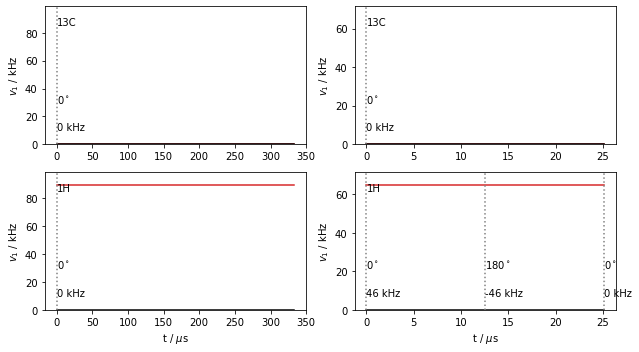

In [8]:
fig,ax=plt.subplots(2,2,figsize=[9,5])
dec.plot(ax=ax.T[0])
fslg.plot(ax=ax.T[1])
_=fig.tight_layout()

Below, we build propagators for steps within the rotor period. The decoupling sequences are in "cyclic" mode by default (`cyclic=True`). In this mode, when we create a propagator from a sequence, it advances the time in the rotor period and the time in the sequence, so the second propagator starts where the previous propagator left off both in the rotor cycle and in the pulse sequence. At the end of the sequence, the propagators will come back to the beginning of the sequence.

Here, we break the rotor cycle up into N-1 steps, and calculate the propagators for each of those steps. This will shorten the calculation time considerably, by avoiding recalculation of the propagators for each step in the DIPSHIFT cycle.

In [9]:
L.reset_prop_time()

step=L.taur/(N-1)
#Propagators for 2*(N-1) steps through two rotor periods
Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] 
Uref=L.Udelta('13C')

L.reset_prop_time()
Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N-1 steps through rotor period

Here, we calculate the refocusing period for the chemical shift. We apply an ideal $^{13}$C $\pi$-pulse, followed by one rotor period of heteronuclear decoupling.

In [10]:
Uref=Upi
for m in range(N-1,2*(N-1)):
    Uref=Udec[m]*Uref

In [11]:
# Run the sequence
L.reset_prop_time()
for k in range(N):
    rho.reset()
    U=Ueye #Initialize the propagator with an identity matrix
    
    # for the first step, we don't use any homonuclear decoupling
    for m in range(k):  # k steps of homonuclear decoupling
        U=Ufslg[m]*U
    
    # for the last step, we only use homonuclear decoupling
    for m in range(k,N-1):  # N-k steps of heteronuclear decoupling
        U=Udec[m]*U
    # Multiply by the U constructed above, then apply the refocusing period, and finally detect
    (Uref*U*rho)()

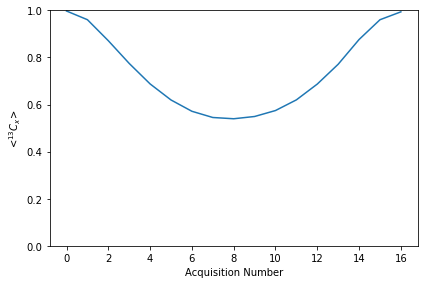

In [12]:
ax=rho.plot()
ax.figure.tight_layout()
_=ax.set_ylim([0,1])

Above, we obtain a typical DIPSHIFT dephasing curve.

Note that DIPSHIFT has a fixed evolution time (we switch between homonuclear and heteronuclear decoupling, but the total evolution time is fixed). Then, when plotting, SLEEPY just uses the Acquisition Number as the x-axis, since all the time points are the same (see `rho.t_axis`).

One may use matplotlib functions to add a time axis, corresponding to the length of the homonuclear decoupling.

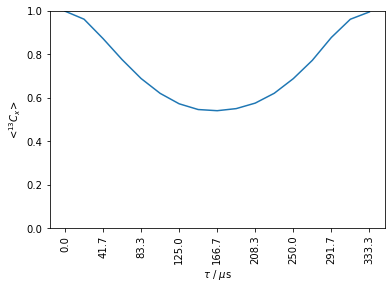

In [13]:
ax=rho.plot()
ff=lambda value,tick_number:f'{L.taur/16*value*1e6:.1f}'
ax.set_xticklabels([],rotation=90)
ax.xaxis.set_major_formatter(plt.FuncFormatter(ff))

_=ax.set_xlabel(r'$\tau$ / $\mu$s')
_=ax.set_ylim([0,1])

## DIPSHIFT as a function of correlation time

In the next section, we will vary the correlation time of motion to see how the DIPSHIFT sequence responses. 

Some caution should be taken when reusing objects. The Liouvillian for the sequences generated from `L` is `L` itself, so the edited `kex` will automatically be relayed to the sequences. However, the propagators are already calculated and will not be re-calculated when kex is changed.

In [17]:
rho0=[]
t0=time()
tc0=np.logspace(-9,-1,9)
for tc in tc0:
    L.kex=sl.Tools.nSite_sym(n=3,tc=tc)
    L.reset_prop_time()

    rho0.append(rho.copy_reduced())

    Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N steps through rotor period
    Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] #Propagators for N steps through two rotor periods
    
    Uref=Upi
    for m in range(N-1,2*(N-1)):
        Uref=Udec[m]*Uref
        
    # Run the sequence
    L.reset_prop_time()
    for k in range(N):
        rho0[-1].reset()
        U=Ueye
        for m in range(k):  # k steps of homonuclear decoupling
            U=Ufslg[m]*U

        for m in range(k,N-1):  # N-k steps of heteronuclear decoupling
            U=Udec[m]*U
        (Uref*U*rho0[-1])() #Propagate rho by U and refocus
        
    print(f'log10(tc/s) = {np.log10(tc):.0f}, {time()-t0:.0f} seconds elapsed')

log10(tc/s) = -9, 15 seconds elapsed
log10(tc/s) = -8, 30 seconds elapsed
log10(tc/s) = -7, 43 seconds elapsed
log10(tc/s) = -6, 55 seconds elapsed
log10(tc/s) = -5, 68 seconds elapsed
log10(tc/s) = -4, 81 seconds elapsed
log10(tc/s) = -3, 95 seconds elapsed
log10(tc/s) = -2, 108 seconds elapsed
log10(tc/s) = -1, 121 seconds elapsed


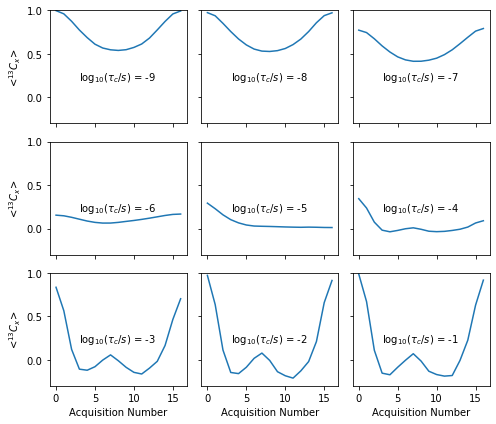

In [18]:
fig,ax=plt.subplots(3,3,figsize=[7,6])
for a,rho1,tc in zip(ax.flatten(),rho0,tc0):
    rho1.plot(ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
        a.set_yticklabels([])
    if not(a.is_last_row()):
        a.set_xlabel('')
        a.set_xticklabels([])
    a.text(3,.2,fr'$\log_{{10}}(\tau_c / s)$ = {np.log10(tc):.0f}')
    a.set_ylim([-.3,1])
    
fig.tight_layout()

Finally, we see the behavior of the DIPSHIFT curve as a function of correlation time. For short correlation times, we get a reduced dipole coupling, whereas for long correlation times, we obtain the full coupling. For intermediate times, we get a broadened curve.